In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cuda:0
Files already downloaded and verified
Files already downloaded and verified


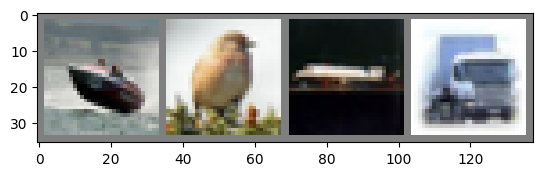

ship  bird  plane truck


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        width = 12
        self.conv1 = nn.Conv2d(3, width, 5).to(device) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2).to(device) # 2x2 pooling
        self.conv2 = nn.Conv2d(width, 16, 5).to(device) # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120).to(device) # 16 channels, 5x5 kernel, 120 output channels
        self.fc2 = nn.Linear(120, 84).to(device) # 120 input channels, 84 output channels
        self.fc3 = nn.Linear(84, 10).to(device) # 84 input channels, 10 output channels
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2): # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
print('Finished Training')

[1,  2000] loss: 2.161
[1,  4000] loss: 1.806
[1,  6000] loss: 1.623
[1,  8000] loss: 1.521
[1, 10000] loss: 1.472
[1, 12000] loss: 1.409
[2,  2000] loss: 1.318
[2,  4000] loss: 1.313
[2,  6000] loss: 1.277
[2,  8000] loss: 1.255
[2, 10000] loss: 1.241
[2, 12000] loss: 1.198
Finished Training


In [6]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

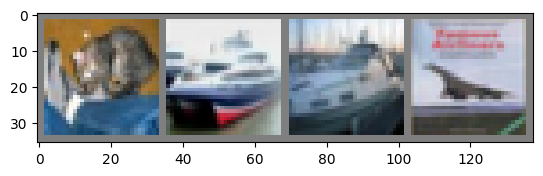

GroundTruth:  cat   ship  ship  plane


In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [9]:
images = images.to(device)
outputs = net(images)

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

Accuracy of the network on the 10000 test images: 56%


In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again, no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s} is: {accuracy:.1f}%')

Accuracy for class plane is: 54.0%
Accuracy for class car   is: 62.9%
Accuracy for class bird  is: 39.6%
Accuracy for class cat   is: 35.2%
Accuracy for class deer  is: 36.8%
Accuracy for class dog   is: 70.8%
Accuracy for class frog  is: 66.3%
Accuracy for class horse is: 58.9%
Accuracy for class ship  is: 82.3%
Accuracy for class truck is: 62.2%
